In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.contrib.parmest import parmest
from pyomo.contrib.parmest.experiment import Experiment
import idaes

## Data

In [2]:
"""
This data and the equation (``Expression``) in pyomo_model is from "Nonlinear Regression Analysis
and Its Applications - 1988 - Bates" p.33 Example

The equation: 
    reaction_velocity = theta[1] * substrate_concentration / (theta[2] + substrate_concentration)
    f(x, theta) = theta[1] * x / (theta[2] + x)
    -> theta[1] and theta[2] are parameters. we want to regress their values
    -> substrate concentration is the decison variable
    -> reaction_velocity is the response

"""
substrate_concentration = np.array([0.02, 0.06, 0.11, 0.22, 0.56, 1.10])
treated_velocity = np.array([
    [76, 47], 
    [97, 107], 
    [123, 139], 
    [159, 152], 
    [191, 201], 
    [207, 200]]
                           )
untreated_velocity = np.array([
    [67, 51], 
    [84, 86], 
    [98, 115], 
    [131, 124], 
    [144, 158], 
    [160, np.nan]]
                             )

# calculate the average velocity. we are taking the average horizontally / along the rows. axis =1
treated_avg_velocity = np.nanmean(treated_velocity, axis = 1)  
untreated_avg_velocity = np.nanmean(untreated_velocity, axis = 1)

data_f = {
    "substrate_concentration": substrate_concentration,
    "treated_avg_velocity": treated_avg_velocity,
    "untreated_avg_velocity": untreated_avg_velocity
       }

# Organizing the data in a list consisting of ``one key : one value dict``s
data_treated = [
    {"substrate_concentration" : float(sub_conc), "avg_velocity": float(treated_vel)} 
    for sub_conc, treated_vel in zip(data_f["substrate_concentration"], data_f["treated_avg_velocity"])
]

data_untreated = [
    {"substrate_concentration" : float(sub_conc), "avg_velocity": float(untreated_vel)} 
    for sub_conc, untreated_vel in zip(data_f["substrate_concentration"], data_f["untreated_avg_velocity"])
]
data_treated[1]

{'substrate_concentration': 0.06, 'avg_velocity': 102.0}

## Creating an experiment class

In [3]:
class ReactionVelcoity(Experiment):

    # Defining the constructor
    def __init__(self, data):
        self.data = data
        self.model = None

    # Creating the get_labeled_model which is a must for ``DOE`` and ``ParmEst``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.label_model()
        return self.model

    # Create the model. In create model we only set variables, parameters and equations 
    def create_model(self):
        m = self.model = pyo.ConcreteModel()

        # initial guess of theta[1] & theta[2]
        theta_initial = {1: 200, 2: 0.06}

        # theta[1] and theta[2] as Vars. theta here is defined as a vector.
        m.s = pyo.RangeSet(2)  # we need a range set b/c we have theta as a vector. 
        # instead of theta, if we used theta_1 and theta_2 with both being scalar. we would not require a range set.
        # I think that would be the easiest way, although using it as a vector is not hard.
        m.theta = pyo.Var(m.s, initialize = theta_initial)

        # substrate concentration (x) as a param, since the data is given          
        m.x = pyo.Param(initialize = self.data["substrate_concentration"])

        # reaction_velocity = f(substrate_concentration, theta), is obtained from this equation.
        # So we will set it as an ``Expression``
        m.reaction_velocity = pyo.Expression(expr = m.theta[1] * m.x / (m.theta[2] + m.x))

        # fix all the regressed model parameters
        m.theta.fix()

        # ======================================
        """
        When I used the built in ``"SSE"``, my model could not find parameter covariance matrix.
        That's why I created the Total_Cost_Obj to minimize the SSE.
        Seems like both ``FirstStageCost`` and ``SecondStageCost`` are required, otherwise it will show ``AttributeError``
        """
        # Stage-specific cost computation
        m.FirstStageCost = pyo.Expression(initialize = 0)
        m.SecondStageCost = pyo.Expression(expr = (self.data["avg_velocity"] - m.reaction_velocity) ** 2)

        m.Total_Cost_Obj = pyo.Objective(expr = (m.FirstStageCost + m.SecondStageCost), sense = pyo.minimize)
        # ======================================

        return m

    def label_model(self):
        """
        The model is updated with outputs, and unknown parameters. This makes the model labeled with full experiment.
        In `ParmEst` output (given data) is the most important. For `DOE` input is most important.
        """
        m = self.model

        # experiment outputs (all the given data)
        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # passing the data as a `list` of `tuple` in the experiment outputs
        m.experiment_outputs.update([
            (m.x, self.data["substrate_concentration"]),
            (m.reaction_velocity, self.data["avg_velocity"])
        ])

        # Unknown parameters
        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((theta, pyo.ComponentUID(theta)) for theta in [m.theta[1], m.theta[2]])

        return m        
    

## Treated velocity

In [4]:
exp_list = []
n_data = len(data_treated)
for i in range(n_data):
    exp_list.append(ReactionVelcoity(data_treated[i]))

# Creating Estimator object
# pest = parmest.Estimator(exp_list, obj_function="SSE", tee = True)
pest = parmest.Estimator(exp_list, tee = True)

obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_data)

print("\n\ntheta values:")
print(theta)

print("\nSSE value: ", obj)

print("\nCovariance matrix:")
print(cov)

Ipopt 3.13.2: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-sca

## Untreated velocity

In [5]:
exp_list = []
data_treated = data_untreated
n_data = len(data_treated)
for i in range(n_data):
    exp_list.append(ReactionVelcoity(data_treated[i]))

# Creating Estimator object
pest = parmest.Estimator(exp_list, tee = True)
obj_u, theta_u = pest.theta_est()

#obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_data)

print("\n\ntheta values:")
print(theta_u)

print("\nSSE value: ", obj)

print("\nCovariance matrix:")
print(cov)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

## Plotting

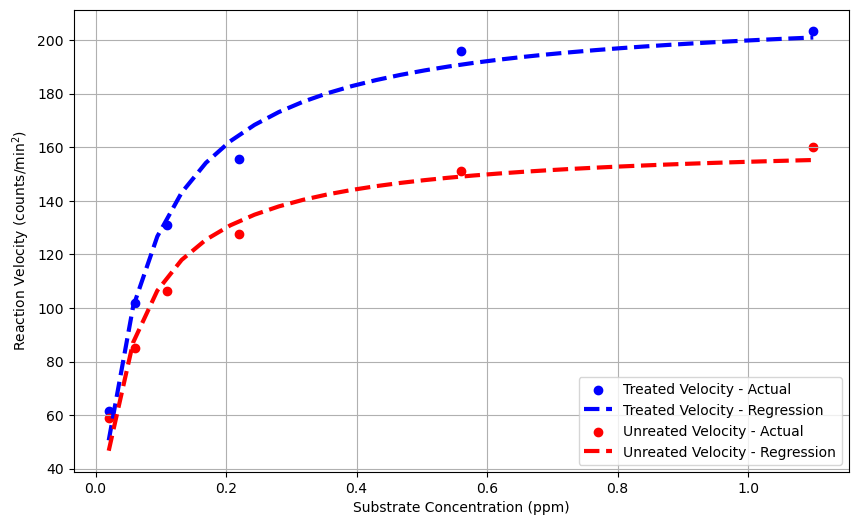

In [6]:
vel = lambda sub_conc, theta: theta.iloc[0] * sub_conc / ( theta.iloc[1] + sub_conc)

sub_c = np.linspace(data_f["substrate_concentration"][0], data_f["substrate_concentration"][-1], 30)

plt.figure(figsize=(10, 6))
# treated data
plt.scatter(data_f["substrate_concentration"], data_f["treated_avg_velocity"], color = "blue", label = "Treated Velocity - Actual")
plt.plot(sub_c, vel(sub_c, theta), lw =3, ls ="--", color = "blue", label="Treated Velocity - Regression")

# untreated data
plt.scatter(data_f["substrate_concentration"], data_f["untreated_avg_velocity"], color = "red", label = "Unreated Velocity - Actual")
plt.plot(sub_c, vel(sub_c, theta_u), lw =3, ls ="--", color = "red", label="Unreated Velocity - Regression")
plt.xlabel("Substrate Concentration (ppm)")
plt.ylabel("Reaction Velocity (counts/min$^2$)")
plt.grid()
plt.legend()

In [7]:
## Likelyhood ratio 